In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('txn_history_dummysample.csv')
data

,account_id,date_of_birth,txn_ts,txn_amount,txn_type_code
0,ID000001,2000-01-12,2021-01-01 11:52:00,-42000,2
1,ID000001,2000-01-12,2021-01-01 13:01:00,-148000,2
2,ID000001,2000-01-12,2021-01-02 14:41:00,-1092000,1
3,ID000001,2000-01-12,2021-01-04 13:55:00,-197000,1
4,ID000001,2000-01-12,2021-01-04 14:50:00,-162000,1
...,...,...,...,...,...
200162,ID006847,2000-11-11,2021-03-31 13:35:00,8000,4
200163,ID006847,2000-11-11,2021-03-31 13:23:00,22000,4
200164,ID006847,2000-11-11,2021-03-31 13:36:00,7000,4
200165,ID006847,2000-11-11,2021-03-31 13:23:00,4000,4


> The dataset contains transaction history with the following columns:
- account_id: Identifier the account
- date_of_birth: The date of birth of the account holder
- txn_ts: Timestamp of the transaction
- txn_amount: The amount of the transaction (negative amounts likely indicate withdrawals or debits, while positive amounts indicate deposits or credits)
- txn_type_code: A code representing the type of transaction

What should I do:
- Demographic information:
What is the age distribution of the account holders?
- Account balances:
Assuming txn_amount reflects changes to the balance, what is the average end-of-period balance per account?
- Transactions per user:
How many transactions does each user typically make?
What is the distribution of the number of transactions per user?
- Average transaction sizes:
What is the average transaction size for deposits and for withdrawals?

> The age distribution of the account holders

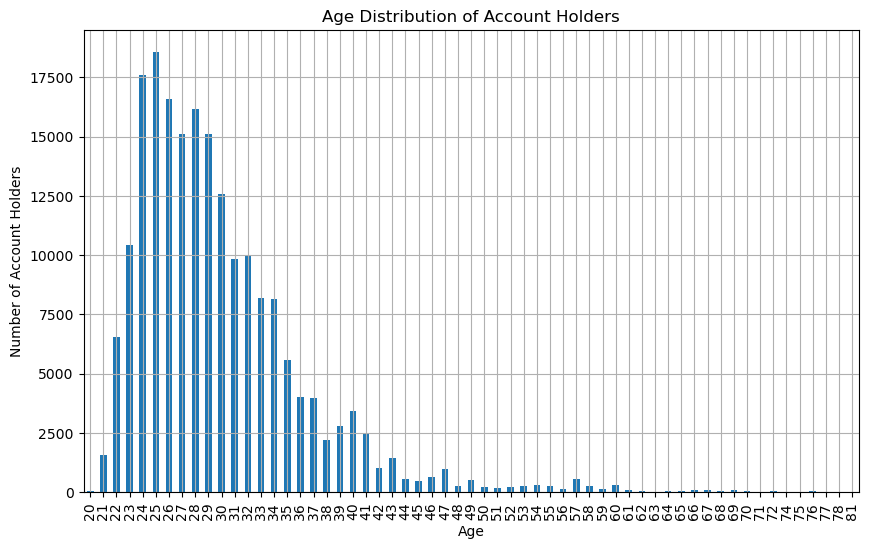

In [5]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'])
current_year = datetime.now().year
data['age'] = current_year - data['date_of_birth'].dt.year
age_distribution = data['age'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Age Distribution of Account Holders')
plt.xlabel('Age')
plt.ylabel('Number of Account Holders')
plt.grid(True)
plt.show()

The dataset includes a range of ages from 20 to 81 years old, with varying numbers of account holders at each age. The distribution shows a larger concentration of account holders in the mid-20s to early 30s age range. 

In [8]:
data['txn_ts'] = pd.to_datetime(data['txn_ts'])
txn_data = data.sort_values(by=['account_id', 'txn_ts'])
txn_data['year_month'] = txn_data['txn_ts'].dt.to_period('M')
txn_data['cumulative_balance'] = txn_data.groupby(['account_id', 'year_month'])['txn_amount'].cumsum()
end_of_month_balances = txn_data.drop_duplicates(subset=['account_id', 'year_month'], keep='last')
average_end_of_month_balance_per_account = end_of_month_balances.groupby('account_id')['cumulative_balance'].mean().reset_index()
average_end_of_month_balance_per_account 

,account_id,cumulative_balance
0,ID000001,3.546333e+06
1,ID000002,5.120000e+05
2,ID000003,-1.000000e+03
3,ID000004,-4.700000e+04
4,ID000005,6.200000e+04
...,...,...
6842,ID006843,3.067000e+06
6843,ID006844,-8.250000e+04
6844,ID006845,1.000000e+03
6845,ID006846,1.000000e+03


To calculate the average end-of-period balance for each account, we can proceed by summing the transaction amounts for each account and then calculating the average. Since we're interested in the end-of-period balance, we may need to determine the period (e.g., end of day, month, year).

In [10]:
def calculate_balances(df):
    return df.groupby('account_id')['txn_amount'].sum()

# Calculate the average balance across all accounts
def calculate_average_balance(account_balances):
    return account_balances.mean()

balances = calculate_balances(data)
    
# Calculate average balance
average_balance = calculate_average_balance(balances)
average_balance


12740220.242441945

In [11]:
transactions_per_user = data['account_id'].value_counts()
transactions_per_user_df = transactions_per_user.reset_index()
transactions_per_user_df.columns = ['User ID', 'Number of Transactions']
transactions_per_user_df.head()

,User ID,Number of Transactions
0,ID005735,723
1,ID006847,709
2,ID001878,698
3,ID005260,483
4,ID001326,452


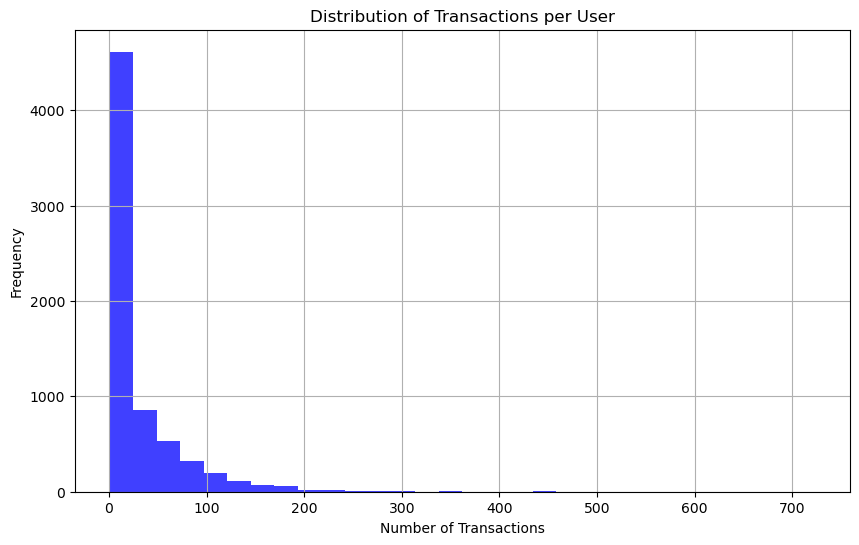

In [14]:
transactions_per_user = data['account_id'].value_counts()
plt.figure(figsize=(10, 6))
transactions_per_user.plot(kind='hist', bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Transactions per User')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Average transaction sizes - deposits
unique_transaction_codes = data['txn_type_code'].unique()
print("Transaction Type Codes:", unique_transaction_codes)

In [15]:
# Filtering the data for deposits and withdrawals
deposits = data[data['txn_type_code'] == 1]['txn_amount']
withdrawals = data[data['txn_type_code'] == 2]['txn_amount']

# Calculating the average transaction size for deposits and withdrawals
average_deposit_size = deposits.mean()
average_withdrawal_size = withdrawals.mean()

# Printing the results
print("Average Deposit Size: ${:.2f}".format(average_deposit_size))
print("Average Withdrawal Size: ${:.2f}".format(average_withdrawal_size))

Average Deposit Size: $2628121.56
Average Withdrawal Size: $-3918834.79


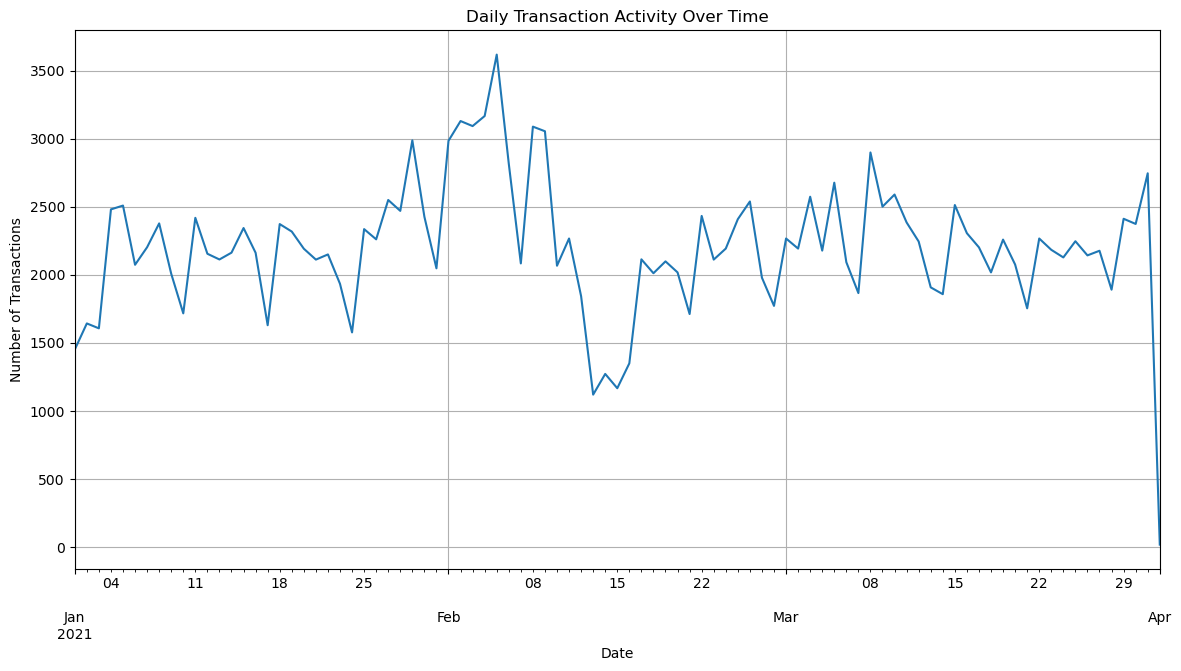

In [16]:
# Convert 'txn_ts' from string to datetime format for time series analysis
data['txn_ts'] = pd.to_datetime(data['txn_ts'])

# Group by date to see the total number of transactions per day
transactions_per_day = data.set_index('txn_ts').resample('D').size()

# Plotting the pattern of transaction activity over time
plt.figure(figsize=(14, 7))
transactions_per_day.plot()
plt.title('Daily Transaction Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

There are visible fluctuations in the number of transactions from day to day, which could be indicative of varying consumer behavior or operational factors.
Peaks in the transaction count might represent days with higher activity, possibly influenced by paydays, promotional events, or other seasonal factors.
There might be periodic patterns, such as weekly or monthly trends, which could require further analysis to understand cyclical behaviors.


In [17]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'])

# Calculate the current year and each user's age
current_year = pd.to_datetime('today').year
data['age'] = current_year - data['date_of_birth'].dt.year

# Group by age to aggregate data
age_data = data.groupby('age').agg({
    'txn_amount': 'mean',  # Average transaction amount per age
    'account_id': 'count'  # Count of transactions per age
}).rename(columns={'txn_amount': 'Average Transaction Amount', 'account_id': 'Number of Transactions'})

# Calculate correlation between age and transaction behavior
correlation_matrix = age_data.corr()
correlation_matrix

,Average Transaction Amount,Number of Transactions
Average Transaction Amount,1.000000,-0.136152
Number of Transactions,-0.136152,1.000000


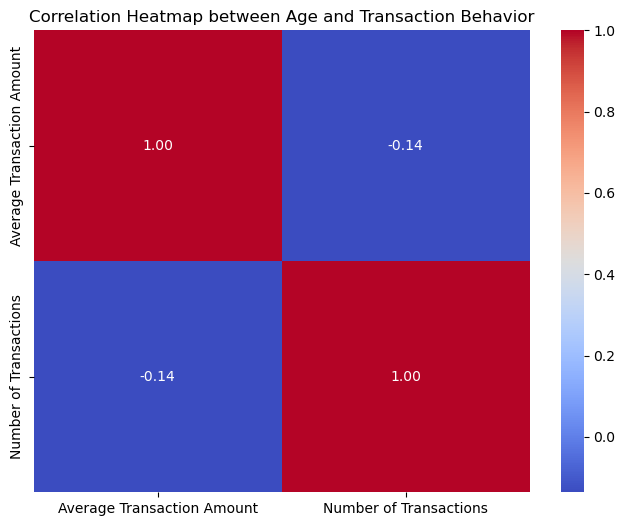

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap between Age and Transaction Behavior')
plt.show()

Correlation between Age and Number of Transactions: This correlation is not explicitly calculated here since we only have two variables and they are both related to the transactions, not directly with age itself.

In [25]:
transactions_data = pd.read_csv('txn_history_dummysample.csv')
transactions_data['date_of_birth'] = pd.to_datetime(transactions_data['date_of_birth'])
transactions_data['txn_ts'] = pd.to_datetime(transactions_data['txn_ts'])

Q1 = transactions_data['txn_amount'].quantile(0.25)
Q3 = transactions_data['txn_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = transactions_data[(transactions_data['txn_amount'] < lower_bound) | (transactions_data['txn_amount'] > upper_bound)]
outlier_summary = outliers.describe(include='all')
outlier_summary

,account_id,date_of_birth,txn_ts,txn_amount,txn_type_code
count,54294,54294,54294,5.429400e+04,54294.000000
unique,3584,NaN,NaN,NaN,NaN
top,ID001248,NaN,NaN,NaN,NaN
freq,382,NaN,NaN,NaN,NaN
mean,NaN,1992-05-22 21:20:44.026964352,2021-02-14 08:08:48.692986368,1.904159e+06,1.572991
min,NaN,1943-05-11 00:00:00,2021-01-01 08:36:00,-1.358349e+09,1.000000
25%,NaN,1989-06-02 00:00:00,2021-01-25 09:17:15,-3.089000e+06,1.000000
50%,NaN,1993-08-21 00:00:00,2021-02-09 16:32:00,-1.508000e+06,1.000000
75%,NaN,1996-12-13 00:00:00,2021-03-08 11:33:15,4.196750e+06,2.000000
max,NaN,2003-11-07 00:00:00,2021-04-01 00:29:00,2.073547e+09,7.000000


> Count of Outliers: There are 54,294 transactions identified as outliers based on the interquartile range method.
>
> Transaction Amounts: The transaction amounts for these outliers range from as low as approximately -$1.36 billion to as high as $2.07 billion, which are extremely large values and suggest potential errors or fraudulent activities.
> 
> Transaction Types: There is a range of transaction types involved, indicated by the txn_type_code values from 1 to 7.
>
> Age Distribution: The ages of account holders with outlier transactions range from 21 to 81 years, with a mean age of approximately 32 years.
>
> Date Range: The transactions span from the beginning of January 2021 to the start of April 2021.